In [ ]:
# Define folder path
folder1 = r"C:\Users\ish\Downloads\spml_final_data\data"  

In [ ]:
import pandas as pd
import os

# Read data in the required format

df_list = []

for filename in os.listdir(folder1):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder1, filename)
        df = pd.read_csv(file_path, header=None, skiprows=1)
        df.drop([1, 2], axis=1, inplace=True)
        
        df.columns = ['Time', 'X', 'Y', 'Z'] # rename the remaining columns as 'Time', 'X', 'Y', 'Z'
        df_list.append(df)

        df['Time'] = df['Time'] // 1  # to ensure integer seconds

        if 'no_handwash' in filename:
            df['Label'] = 'miss'
        else:
            df['Label'] = 'hit'

combined_df = pd.concat(df_list, ignore_index=True)

print("CSV files combined successfully!")

CSV files combined successfully!


In [ ]:
import datetime

# Ensure the 'Time' column is numeric (milliseconds since epoch)
combined_df['Time'] = pd.to_numeric(combined_df['Time'], errors='coerce')

# Convert the 'Time' column from milliseconds to seconds
combined_df['Time_in_seconds'] = combined_df['Time'] / 1000

# Define a function to convert seconds into the format (HH:MM:SS)
def convert_seconds_to_hms(seconds):
    hours = int(seconds // 3600) % 24  # Wrap around after 24 hours
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:06.3f}"  # HH:MM:SS.SSS format

# Apply the conversion function to the 'Time_in_seconds' column
combined_df['Time_HMS'] = combined_df['Time_in_seconds'].apply(convert_seconds_to_hms)

combined_df

,Time,X,Y,Z,Label,Time_in_seconds,Time_HMS
0,5248398799,-0.427511,4.719386,7.677235,hit,5248398.799,17:53:18.799
1,5248398917,0.555644,5.064269,4.994813,hit,5248398.917,17:53:18.917
2,5248398956,1.524430,4.551734,2.429747,hit,5248398.956,17:53:18.956
3,5248398995,1.312471,2.253713,-0.500559,hit,5248398.995,17:53:18.995
4,5248399035,-2.475253,-6.119275,-3.712280,hit,5248399.035,17:53:19.035
...,...,...,...,...,...,...,...
66093,5242998205,0.014914,0.013848,0.002131,miss,5242998.205,16:23:18.205
66094,5242998243,2.927911,-4.566105,7.733518,miss,5242998.243,16:23:18.243
66095,5242998282,3.142266,-3.586542,7.497609,miss,5242998.282,16:23:18.282
66096,5242998321,2.924319,-3.890709,7.562274,miss,5242998.321,16:23:18.321


In [ ]:
import numpy as np

# Ensure 'Time' column is numeric and convert to seconds
combined_df['Time'] = pd.to_numeric(combined_df['Time'], errors='coerce')
combined_df['Time_in_seconds'] = combined_df['Time'] / 1000

# Function to create custom bins based on the desired interval size
def create_bins(seconds, interval_size):
    return (seconds // interval_size).astype(int) * interval_size

# Adjust the interval size here (2, 3, or 4 seconds)
interval_size = 4  

# Create bins for the specified interval size
combined_df['Time_bin'] = create_bins(combined_df['Time_in_seconds'], interval_size)

# Group by the binned time and label
grouped = combined_df.groupby(['Time_bin', 'Label'])

# Define a function to calculate RMS (Root Mean Square)
def rms(series):
    return np.sqrt(np.mean(series**2))

# Calculate the mean, std, median, and RMS for each bin
stats_per_interval = grouped[['X', 'Y', 'Z']].agg(['mean', 'std', 'median', rms])

stats_per_interval.columns = [f'{col[0]}_{col[1]}' for col in stats_per_interval.columns]
stats_per_interval.reset_index(inplace=True)
stats_per_interval.dropna(inplace=True)
stats_per_interval

,Time_bin,Label,X_mean,X_std,X_median,X_rms,Y_mean,Y_std,Y_median,Y_rms,Z_mean,Z_std,Z_median,Z_rms
0,2136940,miss,0.960215,1.598105,0.612499,1.855356,1.813049,2.513069,1.811832,3.085379,7.107751,3.958341,8.222103,8.122956
1,2136944,miss,0.042862,1.561645,0.130253,1.555822,4.165024,4.778710,6.279741,6.324264,4.733664,4.340440,5.904322,6.410349
2,2136948,miss,-0.813513,1.787847,-1.058938,1.957550,3.345261,5.940753,6.031258,6.796619,3.929964,3.994652,4.323010,5.592054
3,2136952,miss,1.613206,1.763909,1.809437,2.385017,-7.209848,3.852854,-8.589139,8.167296,-1.039705,3.006977,-1.234633,3.169981
4,2136956,miss,-4.630633,5.140212,-4.233361,6.902879,-3.114212,4.564592,-1.407214,5.510392,-0.108714,4.484379,-0.301470,4.467435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,5250024,hit,4.994062,6.825253,4.293228,8.433036,-5.058869,5.360572,-4.926555,7.353626,-0.750468,6.827944,-0.664488,6.839230
569,5250028,hit,3.323675,5.136270,3.657195,6.100151,-5.102773,5.079685,-5.193697,7.185402,-0.808283,7.386169,-0.644883,7.400110
570,5250032,hit,3.312744,6.408286,3.240534,7.190341,-5.104227,4.952891,-5.582790,7.097995,-1.173248,6.931823,-1.053809,7.002112
571,5250036,hit,3.224657,5.604409,3.263970,6.446119,-5.378509,4.247196,-6.183940,6.842542,-1.038285,7.093223,-0.873517,7.140224


In [18]:
stats_per_second = stats_per_interval.drop('Time_bin', axis=1)
# Rename 'label' to 'Activity'
stats_per_second.rename(columns={'Label': 'Activity', 'X_mean' : 'mean_x', 'Y_mean' : 'mean_y', 'Z_mean' : 'mean_z', 'X_std' : 'std_x', 'Y_std' : 'std_y', 'Z_std' : 'std_z', 'X_median' : 'median_x', 'Y_median' : 'median_y', 'Z_median' : 'median_z', 'X_rms' : 'rms_x', 'Y_rms' : 'rms_y', 'Z_rms' : 'rms_z'}, inplace=True)

# Move 'Activity' to the end
cols = [col for col in stats_per_second.columns if col != 'Activity'] + ['Activity']
stats_per_second = stats_per_second[cols]

In [19]:
stats_per_second

,mean_x,std_x,median_x,rms_x,mean_y,std_y,median_y,rms_y,mean_z,std_z,median_z,rms_z,Activity
0,0.960215,1.598105,0.612499,1.855356,1.813049,2.513069,1.811832,3.085379,7.107751,3.958341,8.222103,8.122956,miss
1,0.042862,1.561645,0.130253,1.555822,4.165024,4.778710,6.279741,6.324264,4.733664,4.340440,5.904322,6.410349,miss
2,-0.813513,1.787847,-1.058938,1.957550,3.345261,5.940753,6.031258,6.796619,3.929964,3.994652,4.323010,5.592054,miss
3,1.613206,1.763909,1.809437,2.385017,-7.209848,3.852854,-8.589139,8.167296,-1.039705,3.006977,-1.234633,3.169981,miss
4,-4.630633,5.140212,-4.233361,6.902879,-3.114212,4.564592,-1.407214,5.510392,-0.108714,4.484379,-0.301470,4.467435,miss
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,4.994062,6.825253,4.293228,8.433036,-5.058869,5.360572,-4.926555,7.353626,-0.750468,6.827944,-0.664488,6.839230,hit
569,3.323675,5.136270,3.657195,6.100151,-5.102773,5.079685,-5.193697,7.185402,-0.808283,7.386169,-0.644883,7.400110,hit
570,3.312744,6.408286,3.240534,7.190341,-5.104227,4.952891,-5.582790,7.097995,-1.173248,6.931823,-1.053809,7.002112,hit
571,3.224657,5.604409,3.263970,6.446119,-5.378509,4.247196,-6.183940,6.842542,-1.038285,7.093223,-0.873517,7.140224,hit


In [20]:
stats_per_second.to_csv('hit_or_miss_features4.csv', index=False)

In [ ]:
# Classifiers on the entire data

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

file_path = "hit_or_miss_features4.csv"  # Update this with the correct file path
data = pd.read_csv(file_path)

label_encoder = LabelEncoder()
data['Activity'] = label_encoder.fit_transform(data['Activity'])  # 0 for miss, 1 for hit

X = data.drop('Activity', axis=1)
y = data['Activity']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

results = {
    "Random Forest": classification_report(y_test, rf_pred, output_dict=True),
    "Logistic Regression": classification_report(y_test, lr_pred, output_dict=True),
    "Support Vector Machine": classification_report(y_test, svm_pred, output_dict=True)
}

results_df = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy": [r['accuracy'] for r in results.values()],
    "Precision": [r['1']['precision'] for r in results.values()],
    "Recall": [r['1']['recall'] for r in results.values()],
    "F1-Score": [r['1']['f1-score'] for r in results.values()]
})

results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.965217,0.985507,0.957746,0.971429
1,Logistic Regression,0.930435,0.984615,0.901408,0.941176
2,Support Vector Machine,0.956522,0.971429,0.957746,0.964539


In [ ]:
# Classifiers on the selected features

from sklearn.feature_selection import RFE

file_path = "hit_or_miss_features4.csv"  
data = pd.read_csv(file_path)

label_encoder = LabelEncoder()
data['Activity'] = label_encoder.fit_transform(data['Activity'])  # 0 for miss, 1 for hit

X = data.drop('Activity', axis=1)
y = data['Activity']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform feature selection with RFE
rf_model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf_model, n_features_to_select=3)
rfe.fit(X_scaled, y)

# Get the top 3 features
selected_features = X.columns[rfe.support_]
print("Top 3 Features:", selected_features.tolist())

X_selected = X_scaled[:, rfe.support_]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

results = {
    "Random Forest": classification_report(y_test, rf_pred, output_dict=True),
    "Logistic Regression": classification_report(y_test, lr_pred, output_dict=True),
    "Support Vector Machine": classification_report(y_test, svm_pred, output_dict=True)
}

results_df = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy": [r['accuracy'] for r in results.values()],
    "Precision": [r['1']['precision'] for r in results.values()],
    "Recall": [r['1']['recall'] for r in results.values()],
    "F1-Score": [r['1']['f1-score'] for r in results.values()]
})

results_df

Top 3 Features: ['std_x', 'std_y', 'std_z']


,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.961098,0.938697,0.995935,0.966469
1,Logistic Regression,0.954233,0.931298,0.991870,0.960630
2,Support Vector Machine,0.951945,0.924528,0.995935,0.958904


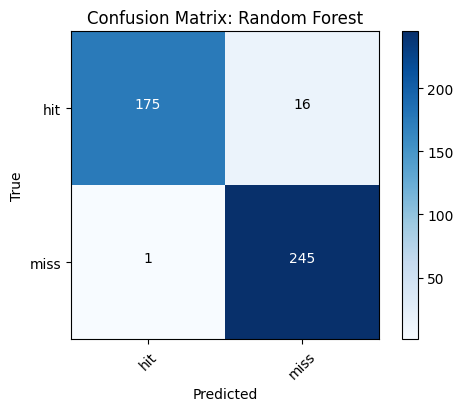

In [48]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(6, 4))
plt.imshow(rf_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Random Forest")
plt.colorbar()
tick_marks = range(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')

# Add numbers in cells
thresh = rf_cm.max() / 2.
for i, j in itertools.product(range(rf_cm.shape[0]), range(rf_cm.shape[1])):
    plt.text(j, i, format(rf_cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if rf_cm[i, j] > thresh else "black")
plt.show()

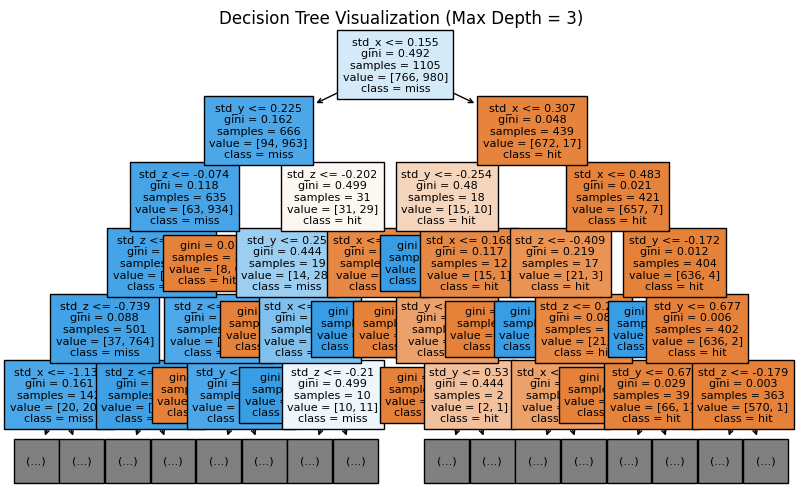

In [ ]:
# Visualize Simplified Decision Tree
plt.figure(figsize=(10, 6))
plot_tree(
    rf_model.estimators_[0],  # First tree in the forest
    feature_names=list(selected_features),  # Convert selected features to list
    class_names=list(label_encoder.classes_),  # Convert class names to list
    filled=True,
    fontsize=8,
    max_depth=3  # Limit to 3 levels
)
plt.title("Decision Tree Visualization (Max Depth = 3)")
plt.show()


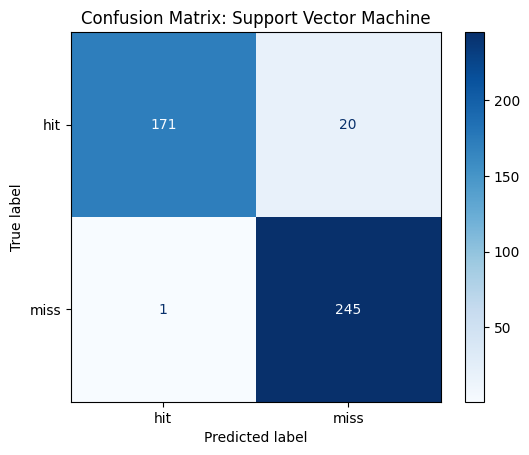

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
svm_cm = confusion_matrix(y_test, svm_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Support Vector Machine",)
plt.show()


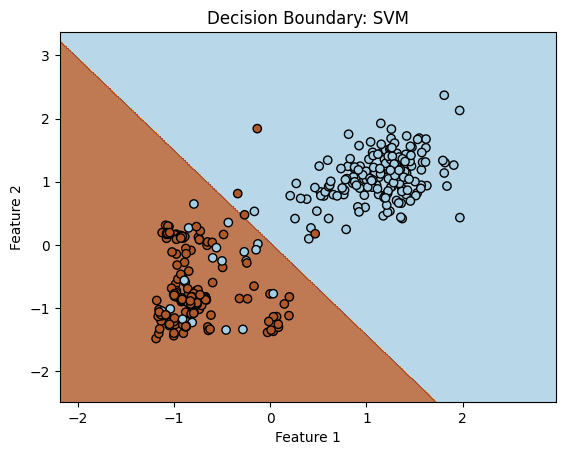

In [56]:
import numpy as np

X_2d = X_test[:, :2]  # Use only the first two features
svm_model_2d = SVC(kernel='linear').fit(X_2d, y_test)  # Train with 2 features

x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = svm_model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_test, edgecolor='k', cmap=plt.cm.Paired)
plt.title("Decision Boundary: SVM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


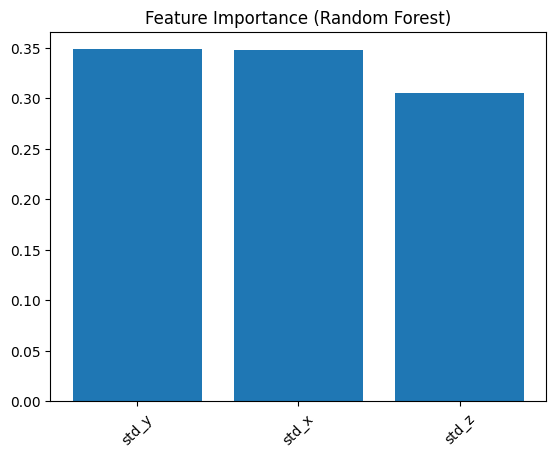

In [59]:
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), np.array(selected_features)[sorted_idx], rotation=45)
plt.title("Feature Importance (Random Forest)")
plt.show()
